In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader

plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style('darkgrid')

In [2]:
dataset = pd.read_csv('/kaggle/input/pimaindiansdiabetes/diabetes.csv')
Y = dataset[['Outcome']]
X = dataset.drop(columns=['Outcome'])

display(Y)
display(X)

# Generate profile report
"""
profile = ProfileReport(dataset)
profile.to_file(output_file='report.html')
"""

FEATURES_LIST = X.columns.values.tolist()

X = X.values
Y = Y.values.ravel()

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)

,Outcome
0,1
1,0
2,1
3,0
4,1
...,...
763,0
764,0
765,0
766,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [3]:
class KNeighborsClassifier():

    def __init__(self, n_neighbors = 5, metric = 'euclidean'):
        self._X = None
        self._Y = None
        self._n_neighbors = n_neighbors
        self._metric = metric

    def fit(self, X, Y):
        self.validate_input(X)
        self._X = X
        self._Y = Y

    def predict(self, x):
        self.validate_input(x)
        distances = distance.cdist(x, self._X, self._metric)
        indices = distances.argsort(axis=1)
        nearest_sample_indices = indices[:, :self._n_neighbors]
        return self._Y[stats.mode(nearest_sample_indices, axis=1)[0].ravel()]

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

For k = 1, train accuracy obtained is: 1.00 and test accuracy obtained is: 0.63
For k = 2, train accuracy obtained is: 0.84 and test accuracy obtained is: 0.65
For k = 3, train accuracy obtained is: 0.80 and test accuracy obtained is: 0.64
For k = 4, train accuracy obtained is: 0.74 and test accuracy obtained is: 0.65
For k = 5, train accuracy obtained is: 0.72 and test accuracy obtained is: 0.65
For k = 6, train accuracy obtained is: 0.70 and test accuracy obtained is: 0.66
For k = 7, train accuracy obtained is: 0.68 and test accuracy obtained is: 0.65
For k = 8, train accuracy obtained is: 0.68 and test accuracy obtained is: 0.67
For k = 9, train accuracy obtained is: 0.69 and test accuracy obtained is: 0.68
For k = 10, train accuracy obtained is: 0.69 and test accuracy obtained is: 0.68


,K,score
0,1,0.629921
1,2,0.645669
2,3,0.637795
3,4,0.645669
4,5,0.645669
5,6,0.661417
6,7,0.653543
7,8,0.673228
8,9,0.677165
9,10,0.677165


Text(0.5, 1.0, 'Accuracy score vs K (KNN)')

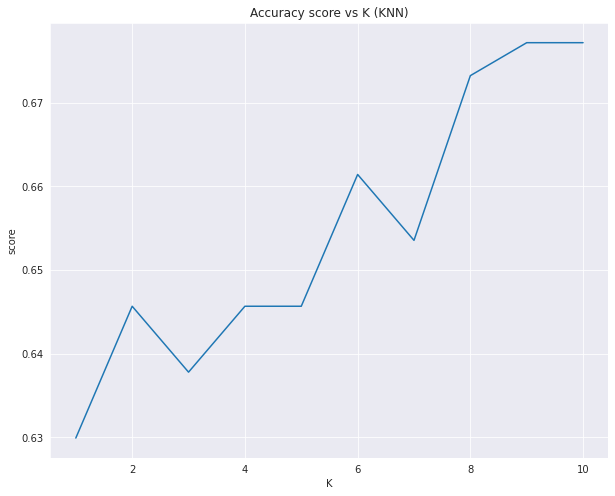

In [4]:
scores = []
K = 10
for k in range(1, K + 1):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(score)
    print(f'For k = {k}, train accuracy obtained is: {train_score:.2f} and test accuracy obtained is: {score:.2f}')

df = pd.DataFrame({'K': list(range(1, K + 1)), 'score': scores})
display(df)
ax = sns.lineplot(data=df, x='K', y='score')
ax.set_title('Accuracy score vs K (KNN)')

In [5]:
class GaussianNBClassifier():

    def __init__(self):
        self._X = None
        self._Y = None

    def fit(self, X, Y):
        self.validate_input(X)
        self._X = X
        self._Y = Y

        # Calculate class probability for each of the classes
        self._class_info = {}
        self._classes = np.unique(Y)
        for c in self._classes:
            samples = X[(Y == c).ravel()]
            means = samples.mean(axis = 0)
            stds  = samples.std(axis = 0)
            self._class_info[c] = {
                'class_prob': (1.0 * len(samples)) / len(X),
                'means': means,
                'stds': stds
            }

    def predict(self, x):
        self.validate_input(x)
        likelihoods = []
        # Calculate for each of the class
        for c in self._classes:
            likelihood = np.log(self._class_info[c]['class_prob'])
            means = self._class_info[c]['means']
            stds  = self._class_info[c]['stds']
            for i in range(self._X.shape[1]):
                likelihood = likelihood + np.log(norm.pdf(x[:, i], loc = means[i], scale = stds[i]))
            likelihoods.append(likelihood)
        likelihoods = np.array(likelihoods).T
        return np.argmax(likelihoods, axis=1)

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

In [6]:
naivebayes = GaussianNBClassifier()
naivebayes.fit(X_train, y_train)
naivebayes.predict(X_test)

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])

In [7]:
print(naivebayes.score(X_train, y_train))
print(naivebayes.score(X_test, y_test))

0.7723735408560312
0.7480314960629921


In [8]:
class DiabetesDataset(Dataset):
    def __init__(self, X, Y):
        self._X = X
        self._Y = Y
    
    def __len__(self):
        return len(self._X)
    
    def __getitem__(self, idx):
        return self._X[idx], self._Y[idx]

In [9]:
class LogisticRegression():
    def __init__(self, n_iter = 200, learning_rate = 0.1, batch_size = 32):
        self._X = None
        self._Y = None
        self._model = None
        self._n_classes = None
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._batch_size = batch_size
    
    def fit(self, X, Y):
        self.validate_input(X)
        self._X = X
        self._Y = Y
        self._n_classes = len(np.unique(Y))
        self._model = self.train(X, Y)
    
    def train(self, X, Y):
        model = nn.Linear(X.shape[1], self._n_classes)
        criterion = nn.CrossEntropyLoss()
        diabetes_dataset = DiabetesDataset(X, Y)
        train_loader = DataLoader(dataset = diabetes_dataset, batch_size = self._batch_size, shuffle = True)
        optimizer = torch.optim.SGD(model.parameters(), lr = self._learning_rate)
        
        for epoch in range(self._n_iter):
            for i, (x, y) in enumerate(train_loader):
                outputs = model(x.float())
                loss = criterion(outputs, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        return model
    
    def predict(self, x):
        outputs = self.test(x)
        return outputs.max(dim=1)[1].numpy()
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def test(self, x):
        with torch.no_grad():
            return self._model(torch.tensor(x).float())
    
    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

In [10]:
logisticreg = LogisticRegression()
logisticreg.fit(X_train, y_train)
logisticreg.predict(X_test)

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [11]:
print(logisticreg.score(X_train, y_train))
print(logisticreg.score(X_test, y_test))

0.6517509727626459
0.7047244094488189


In [12]:
class NeuralNetwork():
    def __init__(self, n_iter = 50, learning_rate = 0.01, batch_size = 16):
        self._X = None
        self._Y = None
        self._model = None
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._batch_size = batch_size
    
    def get_neural_network_model(self):
        return nn.Sequential(
            nn.Linear(self._X.shape[1], 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, self._n_classes)
        )
    
    def fit(self, X, Y):
        self.validate_input(X)
        self._X = X
        self._Y = Y
        self._n_classes = len(np.unique(Y))
        self._model = self.train(X, Y)
    
    def train(self, X, Y):
        model = self.get_neural_network_model()
        criterion = nn.CrossEntropyLoss()
        diabetes_dataset = DiabetesDataset(X, Y)
        train_loader = DataLoader(dataset = diabetes_dataset, batch_size = self._batch_size, shuffle = True)
        optimizer = torch.optim.SGD(model.parameters(), lr = self._learning_rate)
        
        training_losses = []
        for epoch in range(self._n_iter):
            training_loss = 0.
            for i, (x, y) in enumerate(train_loader):
                outputs = model(x.float())
                loss = criterion(outputs, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                training_loss += loss.item()
            training_losses.append(training_loss)
        df = pd.DataFrame({'epochs': list(range(self._n_iter)), 'training loss': training_losses})
        display(df)
        ax = sns.lineplot(data=df, x='epochs', y='training loss')
        ax.set_title('Training loss vs epochs')
        return model
    
    def predict(self, x):
        outputs = self.test(x)
        return outputs.max(dim=1)[1].numpy()
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def test(self, x):
        with torch.no_grad():
            return self._model(torch.tensor(x).float())
    
    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

,epochs,training loss
0,0,34.161504
1,1,22.885532
2,2,22.166906
3,3,21.701792
4,4,21.503121
5,5,21.608014
6,6,21.969319
7,7,20.948364
8,8,20.785265
9,9,21.184725


array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

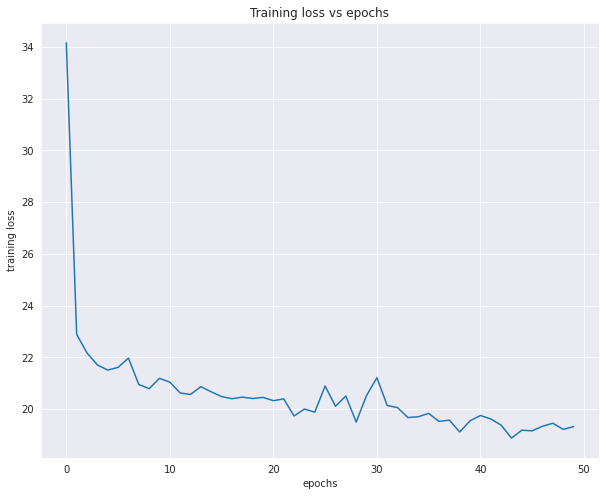

In [13]:
neuralnet = NeuralNetwork()
neuralnet.fit(X_train, y_train)
neuralnet.predict(X_test)

In [14]:
print(neuralnet.score(X_train, y_train))
print(neuralnet.score(X_test, y_test))

0.7276264591439688
0.6929133858267716


In [15]:
class MaxVotingEnsembleTechnique():
    def __init__(self):
        self.X = None
        self.Y = None

    def fit(self, models):
        self.models = models

    def predict(self, x):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(x))
        predictions = np.array(predictions)
        return stats.mode(predictions, axis=0)[0][0]

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [16]:
maxvoting = MaxVotingEnsembleTechnique()
maxvoting.fit([knn, naivebayes, logisticreg, neuralnet])
maxvoting.predict(X_test)

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [17]:
print(maxvoting.score(X_train, y_train))
print(maxvoting.score(X_test, y_test))

0.7354085603112841
0.7440944881889764
